In [154]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
processed_data_dir = Path("data/processed")
interim_data_dir = Path("data/interim")

df = pd.read_csv(interim_data_dir / "02_data.csv")
print("Full preprocessed dataframe:", df.shape)
print(df.head())

X_train = pd.read_csv(processed_data_dir / "X_train.csv")
X_val   = pd.read_csv(processed_data_dir / "X_val.csv")
X_test  = pd.read_csv(processed_data_dir / "X_test.csv")

y_train = pd.read_csv(processed_data_dir / "y_train.csv").squeeze("columns")
y_val   = pd.read_csv(processed_data_dir / "y_val.csv").squeeze("columns")
y_test  = pd.read_csv(processed_data_dir / "y_test.csv").squeeze("columns")

print("Train split:", X_train.shape, y_train.shape)
print("Validation split:", X_val.shape, y_val.shape)
print("Test split:", X_test.shape, y_test.shape)

Full preprocessed dataframe: (54170, 26)
              DateTime  Consumption  Production  Nuclear  Wind  Hydroelectric  \
0  2019-01-01 00:00:00         6352        6527     1395    79           1383   
1  2019-01-01 01:00:00         6116        5701     1393    96           1112   
2  2019-01-01 02:00:00         5873        5676     1393   142           1030   
3  2019-01-01 03:00:00         5682        5603     1397   191            972   
4  2019-01-01 04:00:00         5557        5454     1393   159            960   

   Oil and Gas  Coal  Solar  Biomass  ...  demand_High  hour day_of_week  \
0         1896  1744      0       30  ...        False     0           1   
1         1429  1641      0       30  ...        False     1           1   
2         1465  1616      0       30  ...        False     2           1   
3         1455  1558      0       30  ...        False     3           1   
4         1454  1458      0       30  ...        False     4           1   

   month  hour_

In [113]:
def evaluate_model(model, X_train, y_train, X_test, y_test, name, labels=None, results_dict=None):
    """
    Train, evaluate, and optionally log results for a given model.
    
    Args:
        model: sklearn-compatible model
        X_train, y_train: training data
        X_test, y_test: test data
        labels: list of class labels for reporting
        results_dict: optional dictionary to log results (e.g., for comparison)
    
    Returns:
        y_pred: predictions on the test set
    """
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Report
    print(f"=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, target_names=labels))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix: {name}")
    plt.show()
    
    # Log results
    if results_dict is not None:
        results_dict[name] = {
            "accuracy": accuracy_score(y_test, y_pred),
            "macro_f1": f1_score(y_test, y_pred, average="macro")
        }
    
    return y_pred

In [114]:
labels = ["Low", "Medium", "High"]
results = {}

In [115]:
def establish_baselines(X_train, y_train, X_test, y_test):
    """Establish comprehensive classification baselines"""
 
    # Level 1: Dummy baselines
    dummy_strategies = ['most_frequent', 'stratified', 'uniform']
    for strategy in dummy_strategies:
        dummy = DummyClassifier(strategy=strategy, random_state=42)
        evaluate_model(dummy, X_train, y_train, X_test, y_test, f'DummyClassifier-{strategy}', labels, results)
    
    # Level 2: Simple models
    simple_models = {
        "LogisticRegression-max_iter_1000": LogisticRegression(random_state=42, max_iter=1000),
        "DecisionTree-max_depth_5": DecisionTreeClassifier(max_depth=5, random_state=42)
    }
    for name, model in simple_models.items():
        evaluate_model(model, X_train, y_train, X_test, y_test, name, labels, results)

=== DummyClassifier-most_frequent ===
Accuracy: 0.33339486800812257
Macro F1: 0.16668974110480408

Classification Report:

              precision    recall  f1-score   support

         Low       0.00      0.00      0.00      3612
      Medium       0.33      1.00      0.50      3612
        High       0.00      0.00      0.00      3610

    accuracy                           0.33     10834
   macro avg       0.11      0.33      0.17     10834
weighted avg       0.11      0.33      0.17     10834



/nix/store/dp8mgzs0rvjhl5hr5ka0vqan7sidrhad-python3-3.13.5-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/nix/store/dp8mgzs0rvjhl5hr5ka0vqan7sidrhad-python3-3.13.5-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/nix/store/dp8mgzs0rvjhl5hr5ka0vqan7sidrhad-python3-3.13.5-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

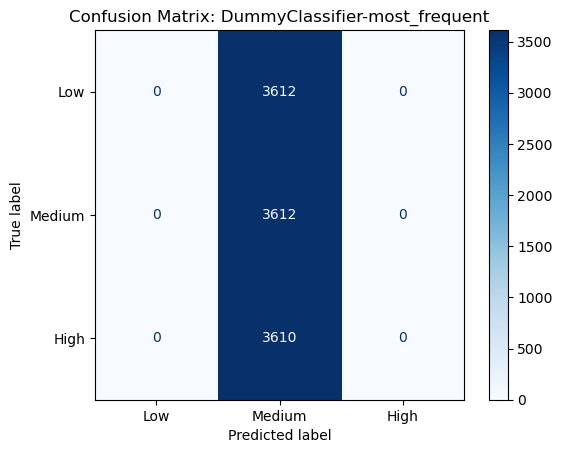

=== DummyClassifier-stratified ===
Accuracy: 0.33902529075133836
Macro F1: 0.33902815125418045

Classification Report:

              precision    recall  f1-score   support

         Low       0.34      0.34      0.34      3612
      Medium       0.34      0.34      0.34      3612
        High       0.34      0.34      0.34      3610

    accuracy                           0.34     10834
   macro avg       0.34      0.34      0.34     10834
weighted avg       0.34      0.34      0.34     10834



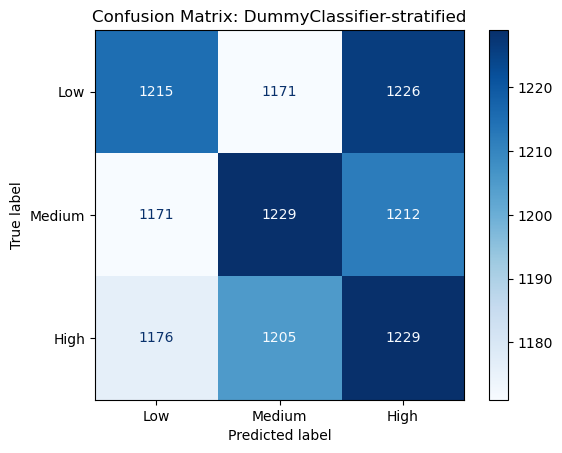

=== DummyClassifier-uniform ===
Accuracy: 0.335148606239616
Macro F1: 0.3351727141062266

Classification Report:

              precision    recall  f1-score   support

         Low       0.33      0.33      0.33      3612
      Medium       0.33      0.33      0.33      3612
        High       0.34      0.34      0.34      3610

    accuracy                           0.34     10834
   macro avg       0.34      0.34      0.34     10834
weighted avg       0.34      0.34      0.34     10834



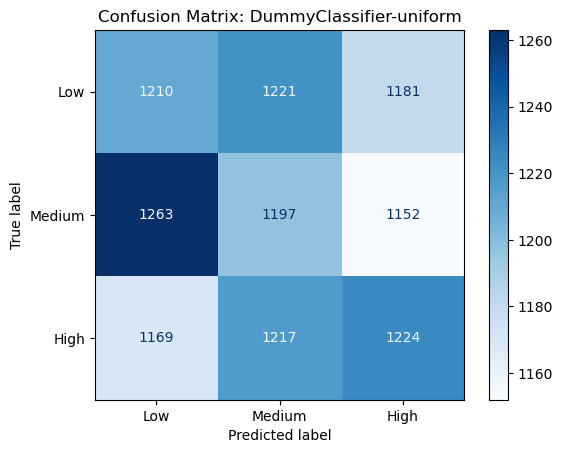

=== LogisticRegression-max_iter_1000 ===
Accuracy: 0.6005168912682296
Macro F1: 0.5935477924357723

Classification Report:

              precision    recall  f1-score   support

         Low       0.66      0.71      0.69      3612
      Medium       0.47      0.39      0.43      3612
        High       0.64      0.70      0.67      3610

    accuracy                           0.60     10834
   macro avg       0.59      0.60      0.59     10834
weighted avg       0.59      0.60      0.59     10834



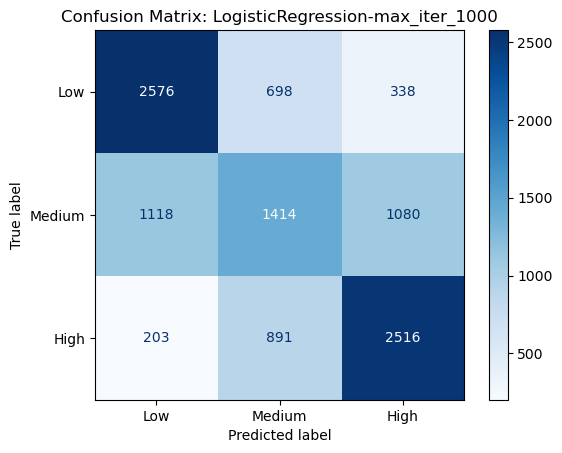

=== DecisionTree-max_depth_5 ===
Accuracy: 0.6822041720509507
Macro F1: 0.6793471233708605

Classification Report:

              precision    recall  f1-score   support

         Low       0.79      0.71      0.75      3612
      Medium       0.57      0.52      0.54      3612
        High       0.69      0.82      0.75      3610

    accuracy                           0.68     10834
   macro avg       0.68      0.68      0.68     10834
weighted avg       0.68      0.68      0.68     10834



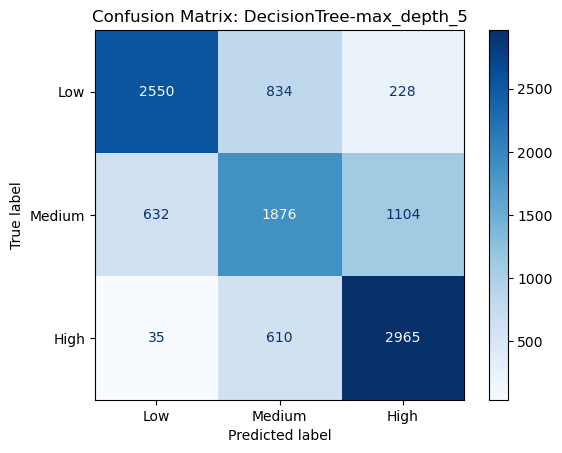

In [116]:
establish_baselines(X_train, y_train, X_test, y_test)

In [117]:
print(json.dumps(results, indent=4))

{
    "DummyClassifier-most_frequent": {
        "accuracy": 0.33339486800812257,
        "macro_f1": 0.16668974110480408
    },
    "DummyClassifier-stratified": {
        "accuracy": 0.33902529075133836,
        "macro_f1": 0.33902815125418045
    },
    "DummyClassifier-uniform": {
        "accuracy": 0.335148606239616,
        "macro_f1": 0.3351727141062266
    },
    "LogisticRegression-max_iter_1000": {
        "accuracy": 0.6005168912682296,
        "macro_f1": 0.5935477924357723
    },
    "DecisionTree-max_depth_5": {
        "accuracy": 0.6822041720509507,
        "macro_f1": 0.6793471233708605
    }
}


In [118]:
def demonstrate_logistic_regression(X_train, y_train, X_val, y_val):
    """Demonstrate logistic regression with interpretation"""
    
    # Train logistic regression
    log_reg = LogisticRegression(random_state=42, max_iter=1000)
    log_reg.fit(X_train, y_train)
    
    # Get predictions and probabilities
    y_pred = log_reg.predict(X_val)
    y_proba = log_reg.predict_proba(X_val)
    
    # Show feature importance (coefficients)
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'coefficient': log_reg.coef_[0],
        'abs_coefficient': np.abs(log_reg.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    
    print("Feature Importance (Coefficients):")
    print(feature_importance.head())
    
    return log_reg, y_pred, y_proba

In [119]:
demonstrate_logistic_regression(X_train, y_train, X_val, y_val)

Feature Importance (Coefficients):
     feature  coefficient  abs_coefficient
0   hour_sin     1.077574         1.077574
1   hour_cos     0.887212         0.887212
2    dow_sin    -0.714139         0.714139
5  month_cos    -0.695986         0.695986
3    dow_cos     0.422689         0.422689


(LogisticRegression(max_iter=1000, random_state=42),
 array([0, 2, 2, ..., 2, 2, 2], shape=(10834,)),
 array([[0.66749332, 0.2938412 , 0.03866548],
        [0.02119127, 0.1958649 , 0.78294383],
        [0.15516541, 0.38646054, 0.45837404],
        ...,
        [0.00433456, 0.11802193, 0.87764352],
        [0.01403113, 0.17796916, 0.80799972],
        [0.1251527 , 0.37776802, 0.49707928]], shape=(10834, 3)))

In [120]:
def demonstrate_decision_tree(X_train, y_train, X_val, y_val):
    """Demonstrate decision tree with visualization and interpretation"""
    
    # Train decision tree with controlled depth
    tree = DecisionTreeClassifier(
        max_depth=5,           # Prevent overfitting
        min_samples_split=20,  # Minimum samples to split
        min_samples_leaf=10,   # Minimum samples in leaf
        random_state=42
    )
    
    tree.fit(X_train, y_train)
    
    # Visualize the tree structure
    plt.figure(figsize=(20, 10))
    plot_tree(tree, 
              feature_names=X_train.columns,
              class_names=labels,
              filled=True,
              rounded=True,
              fontsize=10)
    plt.title("Decision Tree Structure")
    plt.show()
    
    # Get text representation of rules
    tree_rules = export_text(tree, feature_names=list(X_train.columns))
    print("Decision Tree Rules:")
    print(tree_rules[:1000] + "..." if len(tree_rules) > 1000 else tree_rules)
    
    # Feature importance
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': tree.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance:")
    print(importance_df)
    
    return tree

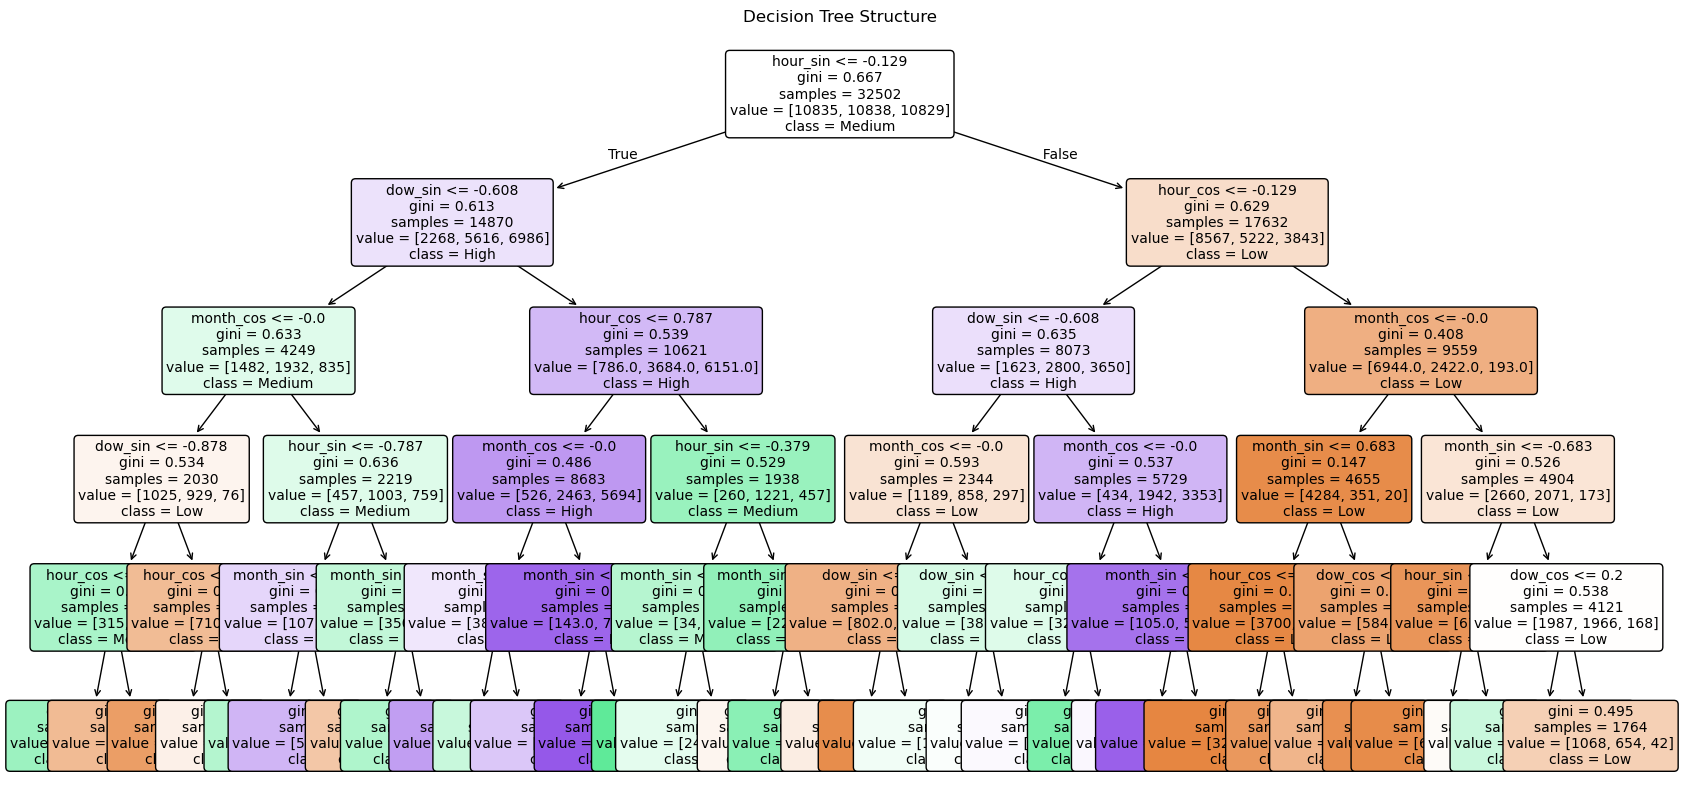

Decision Tree Rules:
|--- hour_sin <= -0.13
|   |--- dow_sin <= -0.61
|   |   |--- month_cos <= -0.00
|   |   |   |--- dow_sin <= -0.88
|   |   |   |   |--- hour_cos <= 0.92
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- hour_cos >  0.92
|   |   |   |   |   |--- class: 0
|   |   |   |--- dow_sin >  -0.88
|   |   |   |   |--- hour_cos <= 0.13
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- hour_cos >  0.13
|   |   |   |   |   |--- class: 0
|   |   |--- month_cos >  -0.00
|   |   |   |--- hour_sin <= -0.79
|   |   |   |   |--- month_sin <= -0.68
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- month_sin >  -0.68
|   |   |   |   |   |--- class: 2
|   |   |   |--- hour_sin >  -0.79
|   |   |   |   |--- month_sin <= -0.68
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- month_sin >  -0.68
|   |   |   |   |   |--- class: 1
|   |--- dow_sin >  -0.61
|   |   |--- hour_cos <= 0.79
|   |   |   |--- month_cos <= -0.00
|   |   |   |   |--- month_sin <= -0.25
|   |   |   

DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=20,
                       random_state=42)

In [121]:
demonstrate_decision_tree(X_train, y_train, X_val, y_val)

=== DecisionTree-max_depth_1 ===
Accuracy: 0.47637068488093043
Macro F1: 0.37995720970513663

Classification Report:

              precision    recall  f1-score   support

         Low       0.48      0.79      0.60      3612
      Medium       0.00      0.00      0.00      3612
        High       0.47      0.64      0.54      3610

    accuracy                           0.48     10834
   macro avg       0.32      0.48      0.38     10834
weighted avg       0.32      0.48      0.38     10834



/nix/store/dp8mgzs0rvjhl5hr5ka0vqan7sidrhad-python3-3.13.5-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/nix/store/dp8mgzs0rvjhl5hr5ka0vqan7sidrhad-python3-3.13.5-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/nix/store/dp8mgzs0rvjhl5hr5ka0vqan7sidrhad-python3-3.13.5-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

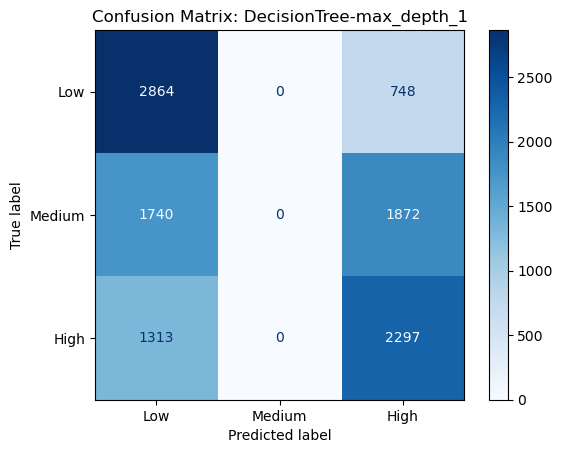

=== DecisionTree-max_depth_3 ===
Accuracy: 0.6288536090086764
Macro F1: 0.5827096414814031

Classification Report:

              precision    recall  f1-score   support

         Low       0.66      0.85      0.74      3612
      Medium       0.54      0.20      0.29      3612
        High       0.63      0.84      0.72      3610

    accuracy                           0.63     10834
   macro avg       0.61      0.63      0.58     10834
weighted avg       0.61      0.63      0.58     10834



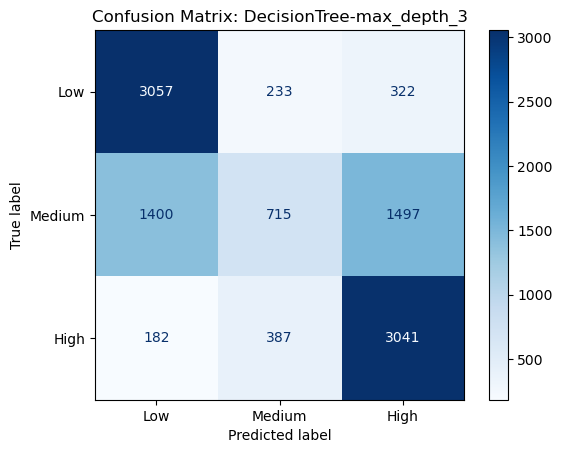

=== DecisionTree-max_depth_10 ===
Accuracy: 0.6288536090086764
Macro F1: 0.5827096414814031

Classification Report:

              precision    recall  f1-score   support

         Low       0.66      0.85      0.74      3612
      Medium       0.54      0.20      0.29      3612
        High       0.63      0.84      0.72      3610

    accuracy                           0.63     10834
   macro avg       0.61      0.63      0.58     10834
weighted avg       0.61      0.63      0.58     10834



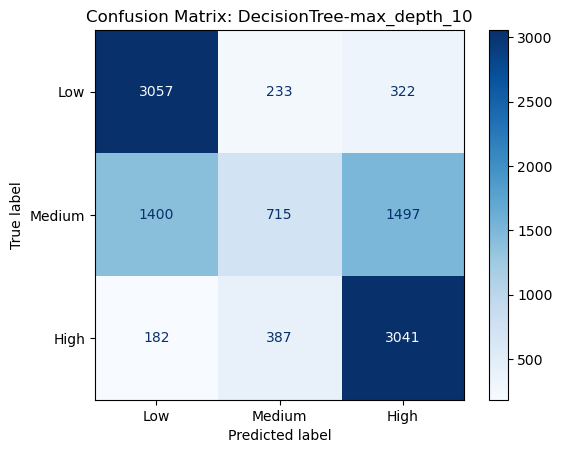

In [122]:
decision_tree_models = {
        "DecisionTree-max_depth_1": DecisionTreeClassifier(max_depth=1, random_state=42),
        "DecisionTree-max_depth_3": DecisionTreeClassifier(max_depth=3, random_state=42),
        "DecisionTree-max_depth_10": DecisionTreeClassifier(max_depth=3, random_state=42),
    }
for name, model in decision_tree_models.items():
    evaluate_model(model, X_train, y_train, X_test, y_test, name, labels, results)

In [123]:
print(json.dumps(results, indent=4))

{
    "DummyClassifier-most_frequent": {
        "accuracy": 0.33339486800812257,
        "macro_f1": 0.16668974110480408
    },
    "DummyClassifier-stratified": {
        "accuracy": 0.33902529075133836,
        "macro_f1": 0.33902815125418045
    },
    "DummyClassifier-uniform": {
        "accuracy": 0.335148606239616,
        "macro_f1": 0.3351727141062266
    },
    "LogisticRegression-max_iter_1000": {
        "accuracy": 0.6005168912682296,
        "macro_f1": 0.5935477924357723
    },
    "DecisionTree-max_depth_5": {
        "accuracy": 0.6822041720509507,
        "macro_f1": 0.6793471233708605
    },
    "DecisionTree-max_depth_1": {
        "accuracy": 0.47637068488093043,
        "macro_f1": 0.37995720970513663
    },
    "DecisionTree-max_depth_3": {
        "accuracy": 0.6288536090086764,
        "macro_f1": 0.5827096414814031
    },
    "DecisionTree-max_depth_10": {
        "accuracy": 0.6288536090086764,
        "macro_f1": 0.5827096414814031
    }
}


In [126]:
def demonstrate_random_forest(X_train, y_train, X_val, y_val):
    """Demonstrate Random Forest with feature importance analysis"""
    
    # Train Random Forest
    rf = RandomForestClassifier(
        n_estimators=100,      # Number of trees
        max_depth=10,          # Maximum depth per tree
        min_samples_split=20,  # Minimum samples to split
        min_samples_leaf=5,    # Minimum samples per leaf
        max_features='sqrt',   # Features per split
        bootstrap=True,        # Use bootstrap sampling
        random_state=42,
        n_jobs=-1             # Use all processors
    )
    
    rf.fit(X_train, y_train)
    
    # Feature importance analysis
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf.feature_importances_,
    }).sort_values('importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    top_features = importance_df.head(10)
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title('Random Forest Feature Importance')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    # Individual tree analysis
    print(f"Number of trees: {rf.n_estimators}")
    print(f"Average tree depth: {np.mean([tree.get_depth() for tree in rf.estimators_]):.1f}")
    print(f"Feature importance (top 5):")
    print(importance_df.head())
    
    return rf, importance_df

# Out-of-bag score evaluation
def analyze_rf_performance(rf, X_train, y_train):
    """Analyze Random Forest performance including OOB score"""
    
    # Create RF with OOB scoring enabled
    rf_oob = RandomForestClassifier(
        n_estimators=100,
        oob_score=True,  # Enable out-of-bag scoring
        random_state=42,
        n_jobs=-1
    )
    
    rf_oob.fit(X_train, y_train)
    
    print(f"Out-of-bag score: {rf_oob.oob_score_:.3f}")
    print("This estimates generalization without validation set!")
    
    return rf_oob

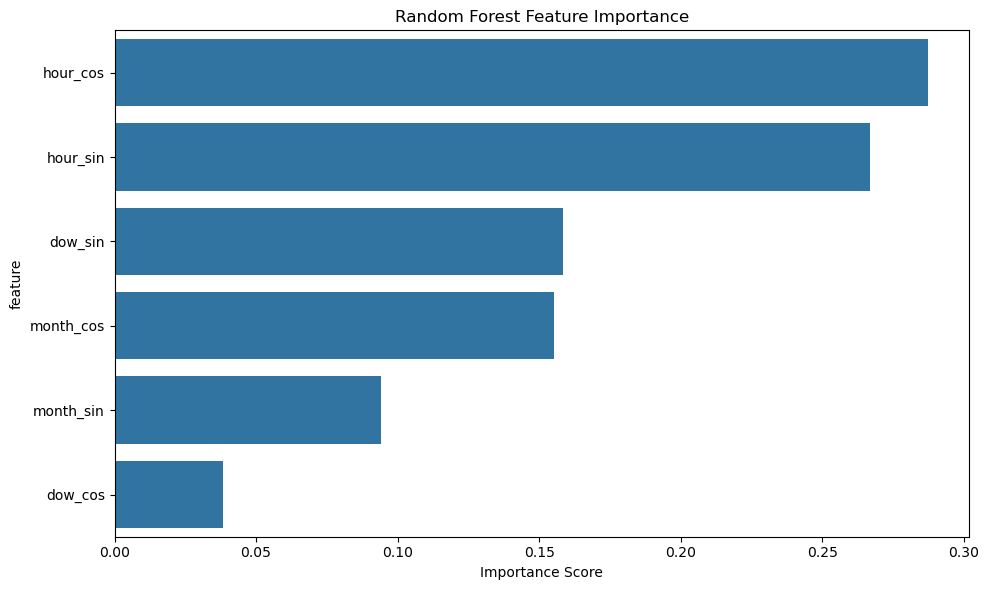

Number of trees: 100
Average tree depth: 10.0
Feature importance (top 5):
     feature  importance
1   hour_cos    0.287323
0   hour_sin    0.266641
2    dow_sin    0.158506
5  month_cos    0.155228
4  month_sin    0.094033


In [127]:
rf, importance_df = demonstrate_random_forest(X_train, y_train, X_val, y_val)

In [128]:
analyze_rf_performance(rf, X_train, y_train)

Out-of-bag score: 0.708
This estimates generalization without validation set!


RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

=== RandomForestClassifier ===
Accuracy: 0.7179250507661067
Macro F1: 0.7169412411625019

Classification Report:

              precision    recall  f1-score   support

         Low       0.82      0.73      0.77      3612
      Medium       0.61      0.59      0.60      3612
        High       0.73      0.83      0.78      3610

    accuracy                           0.72     10834
   macro avg       0.72      0.72      0.72     10834
weighted avg       0.72      0.72      0.72     10834



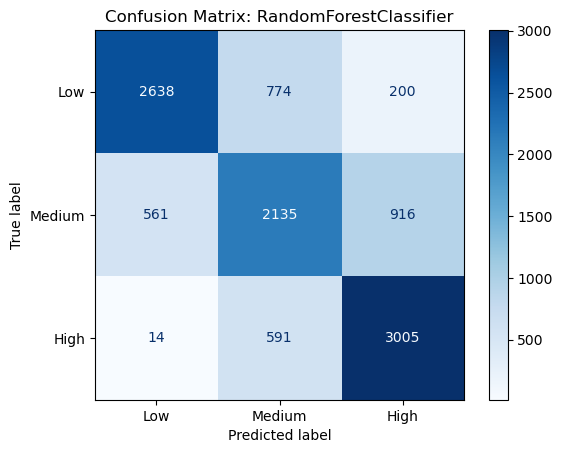

array([1, 0, 2, ..., 1, 0, 2], shape=(10834,))

In [129]:
evaluate_model(rf, X_train, y_train, X_test, y_test, "RandomForestClassifier", labels, results)

In [ ]:
def demonstrate_svm(X_train, y_train, X_val, y_val, scale=False):
    """Demonstrate SVM with different kernels"""
    print()
    print("Scaling enabled" if scale else "Scaling disabled")
    
    # SVM requires feature scaling
    scaler = StandardScaler()
    if scale:
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
    else:
        X_train_scaled = X_train
        X_val_scaled = X_val
    
    # Try different SVM kernels
    kernels = ['linear', 'rbf', 'poly']
    svm_results = {}
    
    for kernel in kernels:
        print(f"\n--- SVM with {kernel} kernel ---")
        
        svm = SVC(
            kernel=kernel,
            C=1.0,                 # Regularization parameter
            gamma='scale',         # Kernel coefficient (for rbf, poly)
            probability=True,      # Enable probability estimates
            random_state=42
        )
        
        svm.fit(X_train_scaled, y_train)
        
        # Performance metrics
        train_score = svm.score(X_train_scaled, y_train)
        val_score = svm.score(X_val_scaled, y_val)
        
        print(f"Training accuracy: {train_score:.3f}")
        print(f"Validation accuracy: {val_score:.3f}")
        print(f"Number of support vectors: {svm.n_support_}")
        print(f"Support vector ratio: {sum(svm.n_support_) / len(X_train):.3f}")
        
        svm_results[kernel] = {
            'model': svm,
            'train_score': train_score,
            'val_score': val_score,
            'n_support': sum(svm.n_support_)
        }
    
    return svm_results

In [140]:
demonstrate_svm(X_train, y_train, X_val, y_val)
demonstrate_svm(X_train, y_train, X_val, y_val, True)

Scaling disabled

--- SVM with linear kernel ---
Training accuracy: 0.597
Validation accuracy: 0.597
Number of support vectors: [ 7321 10838  7485]
Support vector ratio: 0.789

--- SVM with rbf kernel ---
Training accuracy: 0.726
Validation accuracy: 0.714
Number of support vectors: [5075 9637 5579]
Support vector ratio: 0.624

--- SVM with poly kernel ---
Training accuracy: 0.676
Validation accuracy: 0.666
Number of support vectors: [ 6739 10145  6722]
Support vector ratio: 0.726
Scaling enabled

--- SVM with linear kernel ---
Training accuracy: 0.597
Validation accuracy: 0.597
Number of support vectors: [ 7321 10838  7485]
Support vector ratio: 0.789

--- SVM with rbf kernel ---
Training accuracy: 0.726
Validation accuracy: 0.714
Number of support vectors: [5072 9622 5589]
Support vector ratio: 0.624

--- SVM with poly kernel ---
Training accuracy: 0.676
Validation accuracy: 0.668
Number of support vectors: [ 6696 10130  6737]
Support vector ratio: 0.725


{'linear': {'model': SVC(kernel='linear', probability=True, random_state=42),
  'train_score': 0.5974401575287674,
  'val_score': 0.5969171127930589,
  'n_support': np.int32(25644)},
 'rbf': {'model': SVC(probability=True, random_state=42),
  'train_score': 0.7263245338748384,
  'val_score': 0.7139560642422005,
  'n_support': np.int32(20283)},
 'poly': {'model': SVC(kernel='poly', probability=True, random_state=42),
  'train_score': 0.6760814719094209,
  'val_score': 0.6675281521137161,
  'n_support': np.int32(23563)}}

In [ ]:
# Hyperparameter tuning for SVM
def tune_svm_hyperparameters(X_train, y_train):
    """Demonstrate SVM hyperparameter tuning"""
    
    from sklearn.model_selection import GridSearchCV
    
    # Define parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],              # Regularization
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient*
        'kernel': ['rbf', 'poly', 'linear']
    }
    
    svm = SVC(probability=True, random_state=42)
    
    # Grid search with cross-validation*
    grid_search = GridSearchCV(
        svm, param_grid, 
        cv=5, 
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
    
    return grid_search.best_estimator_

In [136]:
#tune_svm_hyperparameters(X_train, y_train)

Exception ignored in: <function ResourceTracker.__del__ at 0x106820040>
Traceback (most recent call last):
  File "/nix/store/pjd6lzr94flz4qg9ycpw09cc26zgfmyl-python3-3.13.5/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/nix/store/pjd6lzr94flz4qg9ycpw09cc26zgfmyl-python3-3.13.5/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/nix/store/pjd6lzr94flz4qg9ycpw09cc26zgfmyl-python3-3.13.5/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
/nix/store/dp8mgzs0rvjhl5hr5ka0vqan7sidrhad-python3-3.13.5-env/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Exception ignored in: <function ResourceTracker.__del__ at 0x123b6c040>
Traceback (most recent call last):
  File "/nix/

Best parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best cross-validation score: 0.722


SVC(C=1, gamma=1, probability=True, random_state=42)

=== SVM ===
Accuracy: 0.7227247553996677
Macro F1: 0.7221770547432823

Classification Report:

              precision    recall  f1-score   support

         Low       0.84      0.71      0.77      3612
      Medium       0.62      0.61      0.61      3612
        High       0.73      0.84      0.78      3610

    accuracy                           0.72     10834
   macro avg       0.73      0.72      0.72     10834
weighted avg       0.73      0.72      0.72     10834



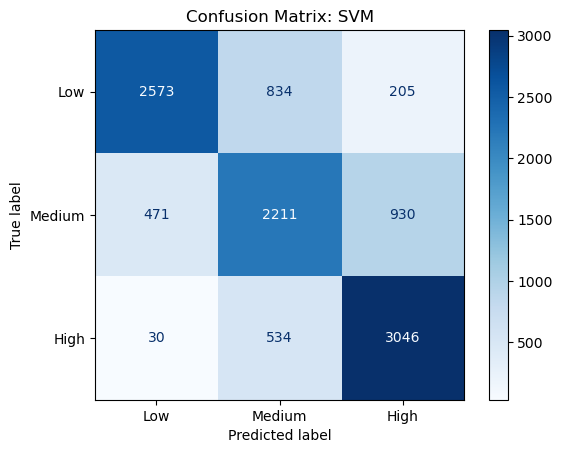

array([1, 0, 2, ..., 1, 0, 2], shape=(10834,))

In [152]:
svm = SVC(
            kernel="rbf",
            C=1.0,                 # Regularization parameter
            gamma=1,         # Kernel coefficient (for rbf, poly)
            probability=True,      # Enable probability estimates
            random_state=42
        )
evaluate_model(svm, X_train, y_train, X_test, y_test, "SVM", labels, results)

In [144]:
def demonstrate_knn(X_train, y_train, X_val, y_val):
    """Demonstrate k-NN with different k values"""
    
    # k-NN is sensitive to scale, so standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Test different k values
    k_values = [1, 3, 5, 10, 20, 50]
    knn_results = {}
    
    for k in k_values:
        knn = KNeighborsClassifier(
            n_neighbors=k,
            weights='uniform',    # or 'distance' for distance weighting
            metric='euclidean',   # distance metric
            n_jobs=-1
        )
        
        knn.fit(X_train_scaled, y_train)
        
        train_score = knn.score(X_train_scaled, y_train)
        val_score = knn.score(X_val_scaled, y_val)
        
        knn_results[k] = {
            'train_score': train_score,
            'val_score': val_score,
            'model': knn
        }
        
        print(f"k={k}: Train={train_score:.3f}, Val={val_score:.3f}")
    
    # Plot k vs accuracy
    plt.figure(figsize=(10, 6))
    k_vals = list(knn_results.keys())
    train_scores = [knn_results[k]['train_score'] for k in k_vals]
    val_scores = [knn_results[k]['val_score'] for k in k_vals]
    
    plt.plot(k_vals, train_scores, 'o-', label='Training Accuracy')
    plt.plot(k_vals, val_scores, 's-', label='Validation Accuracy')
    plt.xlabel('k (Number of Neighbors)')
    plt.ylabel('Accuracy')
    plt.title('k-NN Performance vs k Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return knn_results, scaler

k=1: Train=0.654, Val=0.626
k=3: Train=0.685, Val=0.656
k=5: Train=0.709, Val=0.680
k=10: Train=0.731, Val=0.698
k=20: Train=0.737, Val=0.703
k=50: Train=0.733, Val=0.718


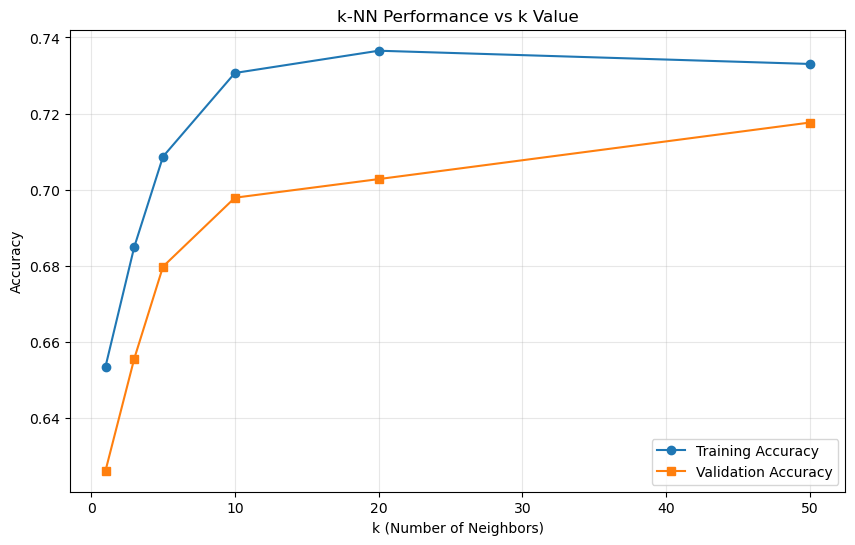

({1: {'train_score': 0.6535290135991632,
   'val_score': 0.6261768506553443,
   'model': KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=1)},
  3: {'train_score': 0.6849732324164667,
   'val_score': 0.6556211925419975,
   'model': KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=3)},
  5: {'train_score': 0.7086948495477201,
   'val_score': 0.6798043197341702,
   'model': KNeighborsClassifier(metric='euclidean', n_jobs=-1)},
  10: {'train_score': 0.7306627284474801,
   'val_score': 0.6978955141222078,
   'model': KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=10)},
  20: {'train_score': 0.7365085225524584,
   'val_score': 0.7027875207679527,
   'model': KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=20)},
  50: {'train_score': 0.7330318134268661,
   'val_score': 0.7176481447295551,
   'model': KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=50)}},
 StandardScaler())

In [145]:
demonstrate_knn(X_train, y_train, X_val, y_val)

In [146]:
# Distance weighting and different metrics
def advanced_knn_options(X_train, y_train, X_val, y_val):
    """Explore advanced k-NN options"""
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Different weighting schemes
    weights = ['uniform', 'distance']
    metrics = ['euclidean', 'manhattan', 'minkowski']
    
    best_score = 0
    best_config = None
    
    for weight in weights:
        for metric in metrics:
            knn = KNeighborsClassifier(
                n_neighbors=5,
                weights=weight,
                metric=metric,
                n_jobs=-1
            )
            
            knn.fit(X_train_scaled, y_train)
            score = knn.score(X_val_scaled, y_val)
            
            print(f"Weights: {weight}, Metric: {metric}, Score: {score:.3f}")
            
            if score > best_score:
                best_score = score
                best_config = (weight, metric)
    
    print(f"\nBest configuration: weights={best_config[0]}, metric={best_config[1]}")
    return best_config

In [147]:
advanced_knn_options(X_train, y_train, X_val, y_val)

Weights: uniform, Metric: euclidean, Score: 0.680
Weights: uniform, Metric: manhattan, Score: 0.680
Weights: uniform, Metric: minkowski, Score: 0.680
Weights: distance, Metric: euclidean, Score: 0.680
Weights: distance, Metric: manhattan, Score: 0.680
Weights: distance, Metric: minkowski, Score: 0.680

Best configuration: weights=uniform, metric=euclidean


('uniform', 'euclidean')

In [150]:
def find_optimal_k(X_train, y_train, max_k=50):
    """Find optimal k using cross-validation"""
    
    from sklearn.model_selection import cross_val_score
    
    k_range = range(1, min(max_k, len(X_train)//5))  # Don't exceed 20% of data
    cv_scores = []
    
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())
    
    optimal_k = k_range[np.argmax(cv_scores)]
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, cv_scores, 'b-')
    plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')
    plt.xlabel('k Value')
    plt.ylabel('Cross-Validation Accuracy')
    plt.title('Finding Optimal k Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Optimal k: {optimal_k}")
    print(f"Best CV score: {max(cv_scores):.3f}")
    
    return optimal_k

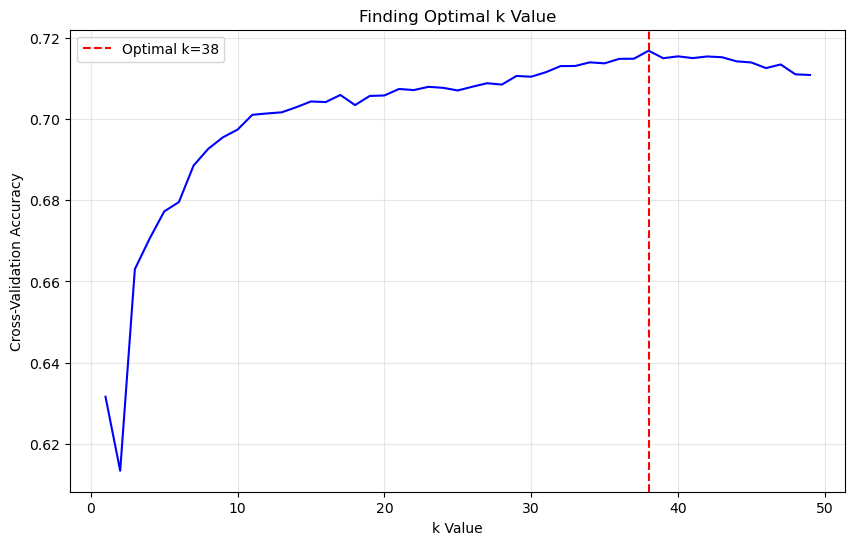

Optimal k: 38
Best CV score: 0.717


38

In [151]:
find_optimal_k(X_train, y_train, max_k=50)

=== KNN ===
Accuracy: 0.7114639099132362
Macro F1: 0.7106696761103782

Classification Report:

              precision    recall  f1-score   support

         Low       0.80      0.74      0.77      3612
      Medium       0.60      0.58      0.59      3612
        High       0.73      0.81      0.77      3610

    accuracy                           0.71     10834
   macro avg       0.71      0.71      0.71     10834
weighted avg       0.71      0.71      0.71     10834



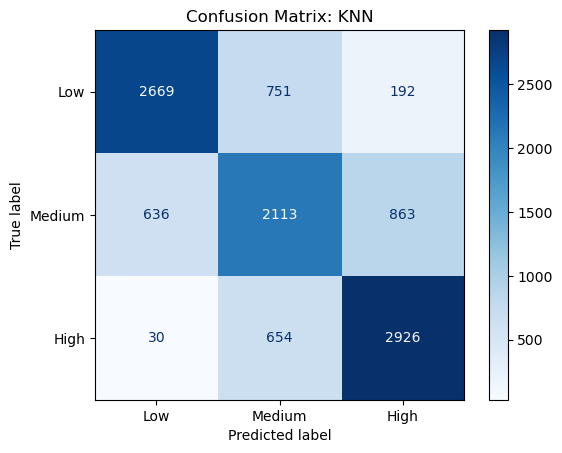

array([1, 0, 2, ..., 1, 0, 2], shape=(10834,))

In [153]:
knn = KNeighborsClassifier(n_neighbors=38)
evaluate_model(knn, X_train, y_train, X_test, y_test, "KNN", labels, results)

In [155]:
def demonstrate_naive_bayes(X_train, y_train, X_val, y_val):
    """Demonstrate different types of Naive Bayes classifiers"""
    
    # Different Naive Bayes variants
    nb_models = {
        'Gaussian': GaussianNB(),           # For continuous features
        'Multinomial': MultinomialNB(),     # For count/frequency features
        'Bernoulli': BernoulliNB()          # For binary features
    }
    
    results = {}
    
    for name, model in nb_models.items():
        try:
            # Some variants require non-negative features
            if name == 'Multinomial':
                X_train_pos = np.where(X_train < 0, 0, X_train)
                X_val_pos = np.where(X_val < 0, 0, X_val)
            else:
                X_train_pos = X_train
                X_val_pos = X_val
            
            model.fit(X_train_pos, y_train)
            
            train_score = model.score(X_train_pos, y_train)
            val_score = model.score(X_val_pos, y_val)
            
            # Get class probabilities
            y_proba = model.predict_proba(X_val_pos)
            
            results[name] = {
                'model': model,
                'train_score': train_score,
                'val_score': val_score,
                'probabilities': y_proba
            }
            
            print(f"{name} Naive Bayes:")
            print(f"  Training accuracy: {train_score:.3f}")
            print(f"  Validation accuracy: {val_score:.3f}")
            
            # Show class priors
            if hasattr(model, 'class_prior_'):
                print(f"  Class priors: {model.class_prior_}")
            
        except Exception as e:
            print(f"{name} Naive Bayes failed: {e}")
    
    return results

In [156]:
demonstrate_naive_bayes(X_train, y_train, X_val, y_val)

Gaussian Naive Bayes:
  Training accuracy: 0.610
  Validation accuracy: 0.608
  Class priors: [0.3333641 0.3334564 0.3331795]
Multinomial Naive Bayes:
  Training accuracy: 0.557
  Validation accuracy: 0.554
Bernoulli Naive Bayes:
  Training accuracy: 0.570
  Validation accuracy: 0.567


{'Gaussian': {'model': GaussianNB(),
  'train_score': 0.6099624638483786,
  'val_score': 0.6083625623038582,
  'probabilities': array([[0.62065943, 0.32059845, 0.05874212],
         [0.06083782, 0.24593206, 0.69323012],
         [0.2386478 , 0.41053881, 0.35081339],
         ...,
         [0.0159996 , 0.18248467, 0.80151573],
         [0.03456645, 0.22592456, 0.73950899],
         [0.17287811, 0.32989143, 0.49723046]], shape=(10834, 3))},
 'Multinomial': {'model': MultinomialNB(),
  'train_score': 0.5574733862531537,
  'val_score': 0.5543658851762968,
  'probabilities': array([[0.49913923, 0.34867007, 0.1521907 ],
         [0.20074102, 0.33610477, 0.46315421],
         [0.23975432, 0.40504776, 0.35519791],
         ...,
         [0.16576445, 0.32133418, 0.51290137],
         [0.20074102, 0.33610477, 0.46315421],
         [0.25654247, 0.35988909, 0.38356844]], shape=(10834, 3))},
 'Bernoulli': {'model': BernoulliNB(),
  'train_score': 0.570457202633684,
  'val_score': 0.5671035628576703

=== NaiveBayes-Gaussian ===
Accuracy: 0.6102086025475355
Macro F1: 0.6006422001043131

Classification Report:

              precision    recall  f1-score   support

         Low       0.66      0.74      0.69      3612
      Medium       0.49      0.38      0.43      3612
        High       0.65      0.71      0.68      3610

    accuracy                           0.61     10834
   macro avg       0.60      0.61      0.60     10834
weighted avg       0.60      0.61      0.60     10834



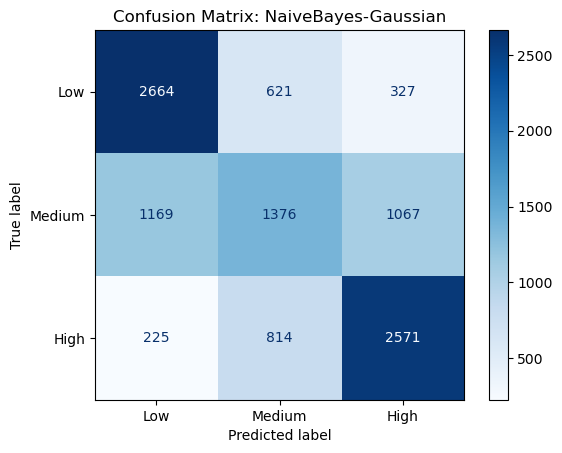

array([1, 0, 2, ..., 1, 0, 2], shape=(10834,))

In [157]:
evaluate_model(GaussianNB(), X_train, y_train, X_test, y_test, "NaiveBayes-Gaussian", labels, results)

In [158]:
print(json.dumps(results, indent=4))

{
    "DummyClassifier-most_frequent": {
        "accuracy": 0.33339486800812257,
        "macro_f1": 0.16668974110480408
    },
    "DummyClassifier-stratified": {
        "accuracy": 0.33902529075133836,
        "macro_f1": 0.33902815125418045
    },
    "DummyClassifier-uniform": {
        "accuracy": 0.335148606239616,
        "macro_f1": 0.3351727141062266
    },
    "LogisticRegression-max_iter_1000": {
        "accuracy": 0.6005168912682296,
        "macro_f1": 0.5935477924357723
    },
    "DecisionTree-max_depth_5": {
        "accuracy": 0.6822041720509507,
        "macro_f1": 0.6793471233708605
    },
    "DecisionTree-max_depth_1": {
        "accuracy": 0.47637068488093043,
        "macro_f1": 0.37995720970513663
    },
    "DecisionTree-max_depth_3": {
        "accuracy": 0.6288536090086764,
        "macro_f1": 0.5827096414814031
    },
    "DecisionTree-max_depth_10": {
        "accuracy": 0.6288536090086764,
        "macro_f1": 0.5827096414814031
    },
    "RandomForestC